# [Jigsaw] Simple LGBM starter using TF-IDF

This is a simple LightGBM starter using TF-IDF only.  
The reason why used TF-IDF only is based on the thought that wheter "toxic" or not would be depending on the existance of the specific violent or obscene words in the sentences.  

Just FYI, I attached improvement history as below.  
As Data description says, there is no training data for this competition. Hence, please add the training data from "jigsaw-toxic-comment-classification-challenge".


TF-IDFを使ったLightGBMによるシンプルなStarterです。  
TF-IDFのみを使ったのは、「害のある文章」かどうかというのは或る特定の語（暴力的・卑猥等）が文章中に存在するかどうかによって決まることが多いのではないかという考えからです。  
ご参考までに、当初のバージョンからの改修履歴を付けました。  

本コンペのData descriptionに記載の通り、このコンペにはTrainingデータがありませんので、過去の"jigsaw-toxic-comment-classification-challenge"からデータを追加してください。

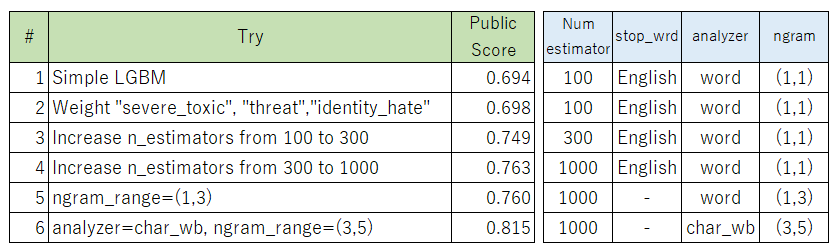



In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgbm

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
comments_df = pd.read_csv("/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv")
valid_df = pd.read_csv("/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv")

comments_df

,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...
...,...,...
7532,504235362,"Go away, you annoying vandal."
7533,504235566,This user is a vandal.
7534,504308177,""" \n\nSorry to sound like a pain, but one by f..."
7535,504570375,Well it's pretty fucking irrelevant now I'm un...


Reading the training data from past "jigsaw-toxic-comment-classification-challenge".

学習用に、過去の「jigsaw-toxic-comment-classification-challenge」のトレーニングデータを読み込む。

In [3]:
prev_train_df = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
prev_train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


From a quick look, we can see "non-toxic" sentences only.  
Let's take a look at "toxic" sentences.  

上記トレーニングデータには、害がない文章しか見えない。害のある文章はどのようなものか見てみる。

In [4]:
prev_train_df[prev_train_df["toxic"] > 0]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0


Then, let's count each factor,meaning, toxic, sever_toxic, obscene, threat, insult and identity_hate.

次に、toxic(害がある)、severe_toxic（非常に害がある）、obscene（猥褻な）、threat（脅しの）、insult（侮蔑的な）、identity_hate（差別的な、と捉えるのがよいのでしょうか）がどの程度あるのか見てみる。

In [5]:
for col in ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"] :
    print(col, prev_train_df[col].sum())

toxic 15294
severe_toxic 1595
obscene 8449
threat 478
insult 7877
identity_hate 1405


Toxic rows are 15,294, which is apprx 10% out of total training data 159,571 rows. It seems almost rows are non-toxic. "threat" is only 478 rows, which is 0.3%.   
Try to weighten some rare items, then newly creat "total_toxic". 

トレーニングデータ159,571行のうち、toxicは15,294で1割程度。殆どが「害のない」文章のようだ。threat（脅し）に至っては478と僅か0.3%。レア度が違うのに、カウントとしては同じ「1」なので、レアな項目の重みを増してみる。  
その上で、「total_toxic」を新設する。

In [6]:
prev_train_df["severe_toxic"] = prev_train_df["severe_toxic"] * 2.5
prev_train_df["threat"] = prev_train_df["threat"] *3
prev_train_df["identity_hate"] = prev_train_df["identity_hate"] * 2

prev_train_df["total_toxic"] = prev_train_df[["toxic", "severe_toxic", "obscene", "threat", "insult",
                                              "identity_hate"]].sum(axis = 1).astype(np.int64)

In [7]:
train_df = prev_train_df[["comment_text", "total_toxic"]]
train_df

,comment_text,total_toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


Try to see how the score will be improved, by changing ngram.  
First, tried to change ngram=(1, 3) with analyzer=default(word), then the score became slightly lower from 0.763 to 0.760.  
Then, tried to change ngram=(3,5) with analyzer=char_wb, then score got improved to 0.815

ngramを変更してどうスコアが変わるかを試してみる。単語単位でngram範囲を1～3で試してみると、スコアは0.763→0.760へと僅かに低下。  
一方、単語単位ではなく、単語内の文字単位(char_wb）でngram範囲を3～5で試してみると、スコアは0.815へと大きく改善。

In [8]:
#tfvec = TfidfVectorizer(stop_words="english")
tfvec = TfidfVectorizer(analyzer = 'char_wb', ngram_range = (3,5))
tfv = tfvec.fit_transform(train_df["comment_text"])

In [9]:
lgb_params = {
    "objective": "regression",
    "n_estimators" : 1000,
    "random_seed" : 1234}

model = lgbm.LGBMRegressor(**lgb_params)

In [10]:
model.fit(tfv, train_df["total_toxic"])

LGBMRegressor(n_estimators=1000, objective='regression', random_seed=1234)

In [11]:
tfv_comments = tfvec.transform(comments_df["text"])
pred = model.predict(tfv_comments)

In [12]:
sub = pd.DataFrame()
sub["comment_id"] = comments_df["comment_id"]
sub["score"] = pred
sub.to_csv('submission.csv',index=False)
sub

,comment_id,score
0,114890,-0.011249
1,732895,0.096420
2,1139051,0.001900
3,1434512,0.004108
4,2084821,1.054603
...,...,...
7532,504235362,0.619846
7533,504235566,-0.000171
7534,504308177,0.081722
7535,504570375,2.525312
